In [3]:
# path to sequence_vaes directory
# abspath = "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
abspath = ".."

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
import json
from treetime.utils import datetime_from_numeric
from collections.abc import Iterable
import matplotlib.cm as cm

# path to sequence_vaes directory and pip install
# %cd "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
# !pip install -r requirements.txt

In [5]:
sys.path.append(abspath)
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import bedford_code.models_bedford as bedford
import utils

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from scipy.optimize._numdiff import approx_derivative

In [6]:
BATCH_SIZE = 64

# "data" directory is generated as shown in README.md file
dataset = DNADataset(f"{abspath}/data/training_spike.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [9]:
input_dim = len(ALPHABET) * SEQ_LENGTH
# input_dim = 29903 * 5
# input_dim = 29903

#STANDARD
vae_model = VAE(input_dim=input_dim, latent_dim=50, non_linear_activation=nn.ReLU()).to(DEVICE)
vae_model.load_state_dict(torch.load("./model_saves/standard_VAE_model_BEST.pth", weights_only=True, map_location=DEVICE))


vae_model.eval()

VAE(
  (non_linear_activation): ReLU()
  (encoder): Encoder(
    (non_linear_activation): ReLU()
    (encode): Sequential(
      (0): Linear(in_features=19110, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
    )
    (fc_mean): Linear(in_features=256, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (non_linear_activation): ReLU()
    (decode): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=19110, bias=True)
    )
  )
)

In [10]:
import utils
dset = ["training", "valid", "test"]
dset = dset[0]
abspath = ".."


# LOAD DATA
data_keys, data_dict = utils.get_data_dict(dset, abspath)
print(data_keys)
new_dataset = data_dict["new_dataset"]
vals = data_dict["vals"]
metadata = data_dict["metadata"]
clade_labels = data_dict["clade_labels"]
collection_dates = data_dict["collection_dates"]
indexes = data_dict["indexes"]
pairs = data_dict["pairs"]
get_parents_dict = data_dict["get_parents_dict"]


collection_dates
 [21, 54, 67, 86, 108, 140, 154, 187, 206, 220, 240, 257, 264, 275, 282, 288, 291, 308, 333, 345, 358, 369, 377, 386, 397, 408, 416, 426, 435, 461, 798, 1373, 2807, 4105, 5241, 6264, 6368]

unique clusters
 ['19A' '21K (BA.1)' '21L (BA.2)' '21M (Omicron)' '22A (BA.4)' '22B (BA.5)'
 '22C (BA.2.12.1)' '22D (BA.2.75)' '22E (BQ.1)' '22F (XBB)'
 '23A (XBB.1.5)' '23B (XBB.1.16)' '23C (CH.1.1)' '23D (XBB.1.9)'
 '23E (XBB.2.3)' '23F (EG.5.1)' '23G (XBB.1.5.70)' '23H (HK.3)'
 '23I (BA.2.86)' '24A (JN.1)' '24D (XDV.1)' '24E (KP.3.1.1)' '24F (XEC)'
 '24G (KP.2.3)' '24H (LF.7)' '24I (MV.1)' '25A (LP.8.1)' '25B (NB.1.8.1)'
 '25C (XFG)']

sanity check - len(new_vals), len(vals)
 6368   6368
['new_dataset', 'vals', 'metadata', 'clade_labels', 'collection_dates', 'indexes', 'pairs', 'get_parents_dict']


In [11]:
vae_model = vae_model.requires_grad_(False)
Z_mean, Z_logvar, recon, genome, genome_recon = utils.model_eval(vae_model, new_dataset, model_type="STANDARD")
Z_mean_np = Z_mean
Z_mean = torch.tensor(Z_mean).to(DEVICE).float()
_, uniq_indices, uniq_inverse = np.unique(genome, axis=0, return_index=True, return_inverse=True)


Recon shape
torch.Size([6368, 19110])


In [12]:
print(vae_model.decoder)

Decoder(
  (non_linear_activation): ReLU()
  (decode): Sequential(
    (0): Linear(in_features=50, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=19110, bias=True)
  )
)


In [13]:
print(Z_logvar.shape)

(6368, 50)


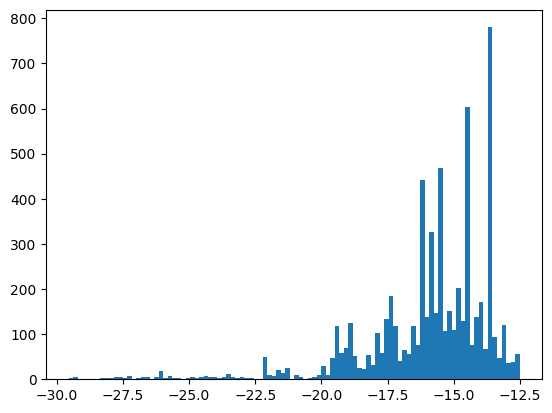

In [14]:
plt.hist(np.sum(Z_logvar,axis=-1), bins=100)
plt.show()

### ARVANITIDIS method

In [12]:
N_train, D = Z_logvar.shape

alpha_rbf = 1000 * np.sqrt(np.exp(Z_logvar)).mean()  # USER CHOICE: the maximum std
zeta_rbf = 1 / (alpha_rbf ** 2)

K_rbf = 100  # Number of rbf centers
W_rbf = torch.rand(D, K_rbf).to(DEVICE)  # The rbf weights
W_rbf.requires_grad_()

kMeans_model = KMeans(n_clusters=K_rbf, n_init=30, max_iter=1000).fit(Z_mean_np)
Labels_rbf = kMeans_model.labels_
optimizer_rbf = torch.optim.Adam(list([W_rbf]), lr=1e-1)

# The centers and the bandwidths initialization
G_rbf = np.zeros((K_rbf, 1))
C_rbf = kMeans_model.cluster_centers_

# Bandwidth selection, min of the diagonal covariance matrix for each cluster
Sigmas = np.zeros((K_rbf, 1))
for k in range(K_rbf):
    inds_k = (Labels_rbf == k)
    points = Z_mean_np[inds_k, :]
    c_k = C_rbf[k, :].reshape(-1, 1)
    S = (np.diag((points - c_k.T).T @ (points - c_k.T))/points.shape[0]).sum()
    Sigmas[k, 0] = np.sqrt(S)

# The final bandwidth
Sigmas = 1.25 * (Sigmas + 1e-12)  # Increase the Sigma by a global factor to smooth the metric a bit
G_rbf = 0.5 / (Sigmas ** 2)

G_rbf = torch.from_numpy(G_rbf.astype(np.float32)).to(DEVICE)
C_rbf = torch.from_numpy(C_rbf.astype(np.float32)).to(DEVICE)

def pairwise_dist2_torch(x, y):
    # x has size (b,d)
    # y has size (c,d)
    
    # want array of size (b,c,d)
    
    x = x.unsqueeze(1)
    y = y.unsqueeze(0)

    dist = torch.pow(x - y, 2).sum(2)
    return dist

# Train the RBF network
def gamma(Z):
    # Z: batch_size x d
    gamma_res = torch.exp(-pairwise_dist2_torch(Z, C_rbf) * G_rbf.T) @ W_rbf.T + zeta_rbf
    return gamma_res

batch_size = 100
rbf_iters = 500
RBF_LOSS = np.zeros((rbf_iters, 1))

Z_logvar_torch = torch.from_numpy(Z_logvar).to(DEVICE)

for iter in range(rbf_iters):
    permutation = np.random.permutation(N_train)

    rbf_loss = 0
    rbf_loss_num = 0

    for i in range(0, N_train, batch_size):
        indices = permutation[i:i + batch_size]

        # Regress the output of the variance network
        LOG_VAR_X_data_batch = Z_logvar_torch[indices,:]  # batch_indices x D
        MU_Z_data_batch = Z_mean[indices, :] # batch_indices x D  
        LOG_VAR_X_eval = -torch.log(gamma(MU_Z_data_batch))

        # Compute a MSE loss
        loss = ((LOG_VAR_X_data_batch - LOG_VAR_X_eval) ** 2).sum(1).mean(0)

        # Update the parameters
        optimizer_rbf.zero_grad()
        loss.backward()
        optimizer_rbf.step()
        W_rbf.data.clamp_(min=1e-5)
        rbf_loss += loss.item()
        rbf_loss_num += 1

    RBF_LOSS[iter, 0] = rbf_loss / rbf_loss_num
    if iter % 100 == 0:
        print("[RBF training] [Iter: {}/{}] [objective: {:.3f}]"
              .format(iter, rbf_iters, RBF_LOSS[iter, 0]))

[RBF training] [Iter: 0/500] [objective: 33.318]
[RBF training] [Iter: 100/500] [objective: 4.004]
[RBF training] [Iter: 200/500] [objective: 3.771]
[RBF training] [Iter: 300/500] [objective: 3.802]
[RBF training] [Iter: 400/500] [objective: 3.841]


In [13]:
# rbf jacobian
def d_gamma(Z):
    diff = -2 * (Z[:,None,:] - C_rbf[None,:,:]) # (b,c,d), where c=#clusters
    val1 = G_rbf[None,:,:] * torch.exp(-pairwise_dist2_torch(Z, C_rbf) * G_rbf.T)[:,:,None] # (b,c,1)
    return diff * val1 # (b,c,d)

# rbf riemannian metric
def get_rbf_correction(Z):
    jac = d_gamma(Z)
    manifold_metric_var = torch.einsum("bij,bjk->bik", torch.permute(jac, (0, 2, 1)), jac)
    return manifold_metric_var

# compute riemannian metric at different points
def get_riemannian_metric(X):

    # jacrev combined with vmap for very fast batched jacobian compuation 
    # Jac has dimensions (b, x_dim, z_dim)
    jac = torch.func.vmap(torch.func.jacrev(vae_model.decoder.decode))(X)
    # batched Jac^T * Jac
    # metric has dimensions (b, z_dim, z_dim)
    manifold_metric = torch.einsum("bij,bjk->bik", torch.permute(jac, (0, 2, 1)), jac)
    
    # print(metric.shape)
    return manifold_metric

def get_metrics(X):
    print(X.shape)
    batch_len = 20

    n_reps = X.shape[0] // batch_len
    if batch_len * n_reps < X.shape[0]:
        n_reps += 1
    
    batches = []
    for i in range(n_reps):
        s = i * batch_len
        e = s + batch_len
    
        batch = X[s:e]
        
        batches.append(get_riemannian_metric(batch) + get_rbf_correction(batch))
        print(".",end="")

    return batches

def get_det_metric(metric):
    return 0.5 * torch.log(torch.linalg.det(torch.cat(metric, dim=0)) + 1e-10).cpu().numpy()

In [14]:
Z_mean_np = Z_mean.cpu().numpy()

pca = PCA(n_components=4, svd_solver="full")
pca.fit(Z_mean_np - np.mean(Z_mean_np))
variances = pca.explained_variance_ratio_
tot = np.sum(variances)

print(variances, "\n")
print(f"total variance: {tot}")

[0.40960428 0.28285992 0.21266271 0.07270278] 

total variance: 0.9778296947479248


In [15]:
N_components = 2
pca = PCA(n_components=N_components, svd_solver="full")
pca.fit(Z_mean_np - np.mean(Z_mean_np))
Z_embedded = pca.transform(Z_mean_np - np.mean(Z_mean_np))

xmax, ymax = np.max(Z_embedded, axis=0) + 0.5
xmin, ymin = np.min(Z_embedded, axis=0) - 0.5

In [16]:
Z_mean_recon = pca.inverse_transform(Z_embedded)

In [17]:
print(Z_mean_recon.shape)
print(Z_mean_np.shape)

print(np.sum(np.abs((Z_mean_recon + np.mean(Z_mean_np))  - Z_mean_np)) / (Z_mean_np.shape[0] * Z_mean_np.shape[0]))

(6368, 50)
(6368, 50)
0.0005203588650487342


In [18]:
N = 40
X,Y = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))

space = np.concatenate((X.ravel()[:, None], Y.ravel()[:, None]), axis=-1)
space_recon = pca.inverse_transform(space) + np.mean(Z_mean_np)

In [21]:
batched_jac = get_metrics(torch.tensor(space_recon).to(DEVICE).float())
space_recon_metrics = get_det_metric(batched_jac).reshape(X.shape)
print(space_recon_metrics.shape)

torch.Size([1600, 50])
................................................................................(40, 40)


In [23]:
z_metrics = get_det_metric(get_metrics(Z_mean[uniq_indices]))
print(z_metrics.shape)

torch.Size([1593, 50])
................................................................................(1593,)


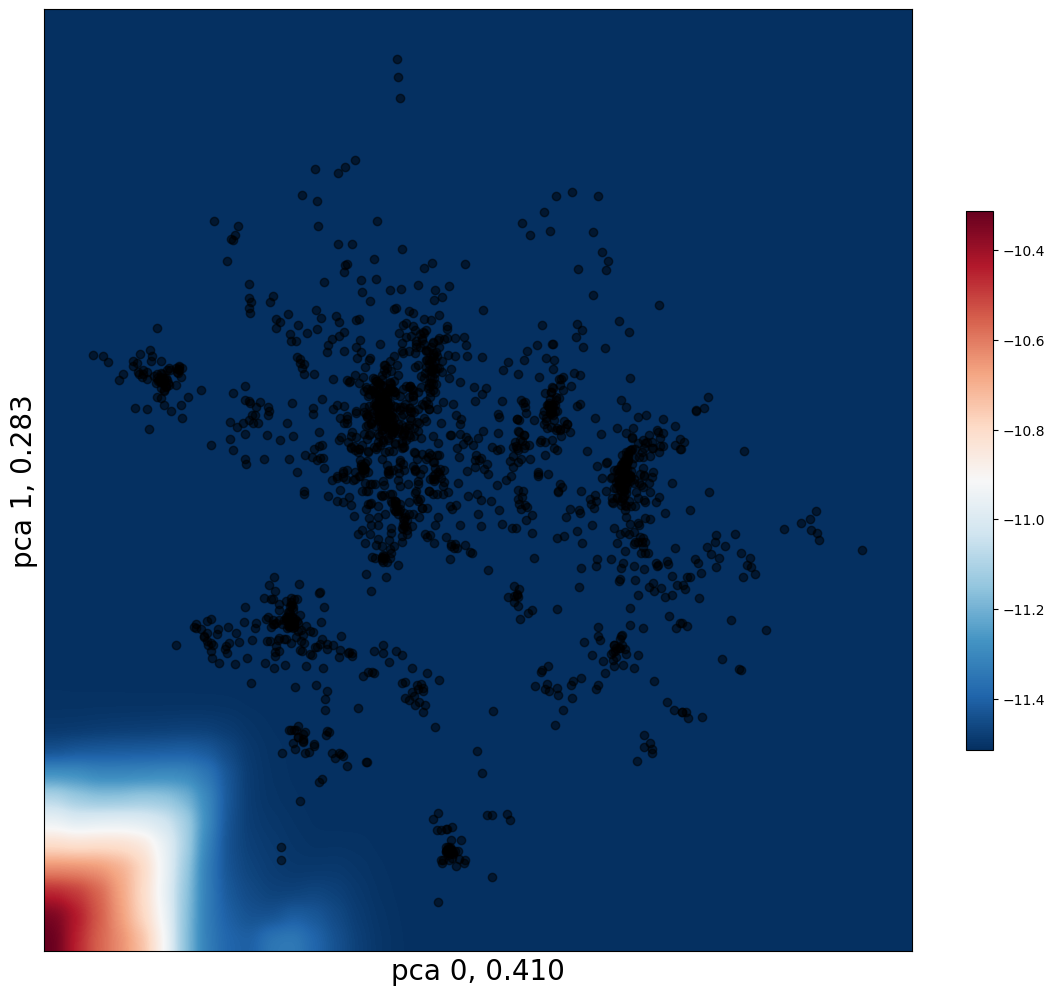

In [24]:
fig,arr = plt.subplots(1,1,figsize=(14,14))

vmin = np.min([np.min(z_metrics), np.min(space_recon_metrics)])
vmax = np.max([np.max(z_metrics), np.max(space_recon_metrics)])

# scatterplot = plt.scatter(Z_embedded[uniq_indices,0], Z_embedded[uniq_indices,1], c=z_metrics, cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)
arr.scatter(Z_embedded[uniq_indices,0], Z_embedded[uniq_indices,1], color="black", alpha=0.5)
display = plt.imshow(space_recon_metrics, interpolation='gaussian', origin='lower',
               extent=(xmin, xmax, ymin, ymax),
               cmap=cm.RdBu_r, aspect='equal', vmin=vmin, vmax=vmax)
plt.colorbar(display,  shrink=0.5)

plt.xticks([])
plt.yticks([])
plt.xlabel("pca 0, %.3f"%(variances[0]), fontsize=20)
plt.ylabel("pca 1, %.3f"%(variances[1]), fontsize=20)

plt.show()

### CHADEBEC method

In [17]:
Z_mean_np = Z_mean.cpu().numpy()

pca = PCA(n_components=4, svd_solver="full")
pca.fit(Z_mean_np - np.mean(Z_mean_np))
variances = pca.explained_variance_ratio_
tot = np.sum(variances)

print(variances, "\n")
print(f"total variance: {tot}")

[0.37639263 0.2935206  0.2551166  0.05975439] 

total variance: 0.9847842454910278


In [19]:
N_components = 2
pca = PCA(n_components=N_components, svd_solver="full")
pca.fit(Z_mean_np - np.mean(Z_mean_np))
Z_embedded = pca.transform(Z_mean_np - np.mean(Z_mean_np))

xmax, ymax = np.max(Z_embedded, axis=0) + 0.5
xmin, ymin = np.min(Z_embedded, axis=0) - 0.5

In [20]:
Z_mean_recon = pca.inverse_transform(Z_embedded)

In [21]:
print(Z_mean_recon.shape)
print(Z_mean_np.shape)

print(np.sum(np.abs((Z_mean_recon + np.mean(Z_mean_np))  - Z_mean_np)) / (Z_mean_np.shape[0] * Z_mean_np.shape[0]))

(6368, 50)
(6368, 50)
0.0006307726818360313


In [46]:
N = 100
X,Y = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))

space = np.concatenate((X.ravel()[:, None], Y.ravel()[:, None]), axis=-1)
space_recon = pca.inverse_transform(space) + np.mean(Z_mean_np)

In [47]:
c = 250
kmedoids = KMedoids(n_clusters=c, random_state=1, init="k-medoids++").fit(Z_mean[uniq_indices, :].cpu().numpy())
kmed_index = [uniq_indices[x] for x in kmedoids.medoid_indices_]
Z_var = torch.tensor(np.exp(Z_logvar)).to(DEVICE)

mu = Z_mean[kmed_index,:]
sigma = Z_var[kmed_index,:]

rho = utils.compute_rho(mu)

In [50]:
lam = 1
eps=1e-8

space_recon_metrics_chadebec = utils.G_batched(torch.tensor(space_recon).to(DEVICE).float(), mu, sigma, rho, lam=lam, eps=eps).cpu().numpy()
space_recon_metrics_chadebec = 0.5 * np.sum(np.log(space_recon_metrics_chadebec), axis=-1).reshape(X.shape)

z_metrics_chadebec = utils.G_batched(Z_mean[uniq_indices,:], mu, sigma, rho, lam=lam, eps=eps).cpu().numpy()
z_metrics_chadebec = 0.5 * np.sum(np.log(z_metrics_chadebec), axis=-1)

print(space_recon_metrics_chadebec.shape)
print(z_metrics_chadebec.shape)

(100, 100)
(1593,)


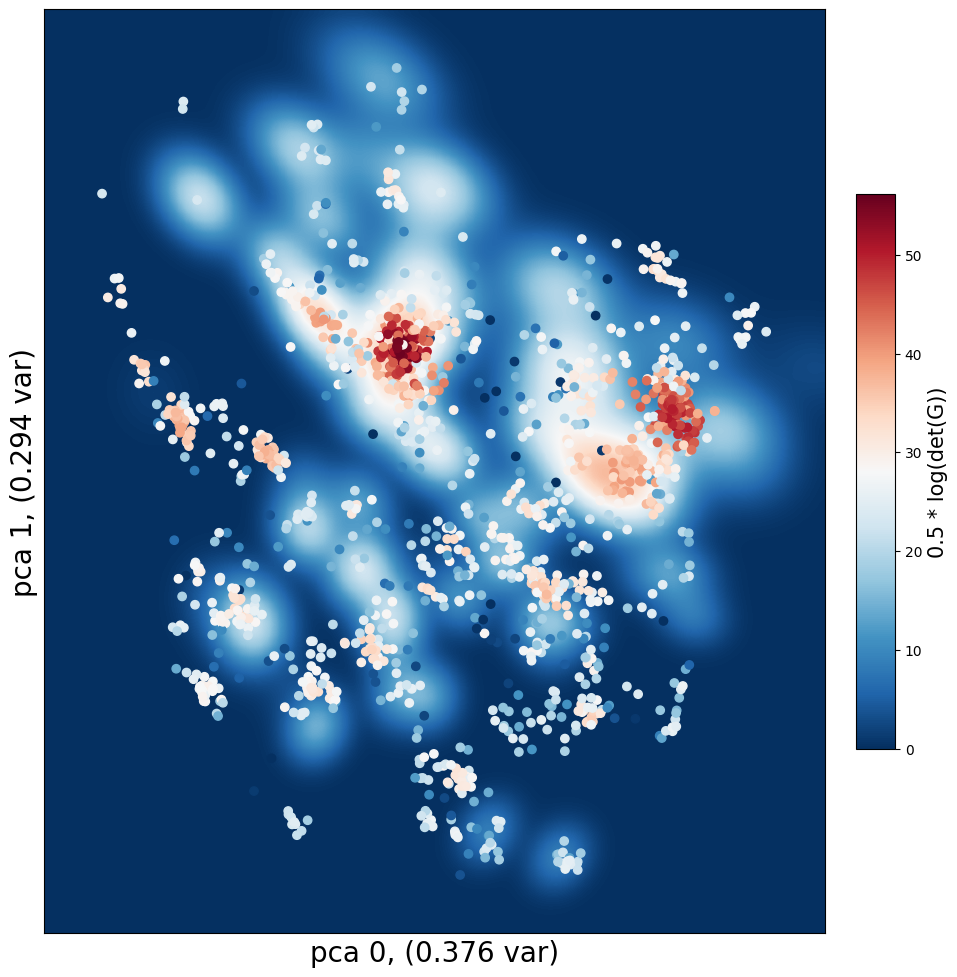

In [51]:
fig,arr = plt.subplots(1,1,figsize=(12,12))

vmin = np.min([np.min(z_metrics_chadebec), np.min(space_recon_metrics_chadebec)])
vmax = np.max([np.max(z_metrics_chadebec), np.max(space_recon_metrics_chadebec)])

arr.scatter(Z_embedded[uniq_indices,0], Z_embedded[uniq_indices,1], c=z_metrics_chadebec, cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)
# arr.scatter(Z_embedded[uniq_indices,0], Z_embedded[uniq_indices,1], color="black", alpha=0.5)
display = arr.imshow(space_recon_metrics_chadebec, interpolation='gaussian', origin='lower',
               extent=(xmin, xmax, ymin, ymax),
               cmap=cm.RdBu_r, aspect='equal', vmin=vmin, vmax=vmax)

plt.xticks([])
plt.yticks([])
plt.xlabel("pca 0, (%.3f var)"%(variances[0]), fontsize=20)
plt.ylabel("pca 1, (%.3f var)"%(variances[1]), fontsize=20)

cax = arr.inset_axes([1.04, 0.2, 0.05, 0.6])
cbar = plt.colorbar(display, cax=cax, shrink=0.25)
cbar.set_label('0.5 * log(det(G))', fontsize=15)


plt.show()